# Cluster Analysis
In this section, we are going to cluster the countries based on their charecteristics. The aim is to tackle one of our research questions.

In [2]:
pip install pygal-maps-world

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 270 kB 5.4 MB/s 
     |████████████████████████████████| 129 kB 59.4 MB/s 
  Created wheel for pygal-maps-world: filename=pygal_maps_world-1.0.2-py3-none-any.whl size=278561 sha256=b64eb503d3dcf4ea0f8279e65ca869c10c41184f2f5273decb09ba28e2ab2c32
  Stored in directory: /root/.cache/pip/wheels/54/e6/11/5be0d3206bdc0ea8f0fcf1fe32661d7e614863c8b6a22655ae
Successfully built pygal-maps-world


In [3]:
pip install pygal


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# loading the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.cluster import KMeans # Our clustering algorithm
from sklearn.decomposition import PCA # Needed for dimension reduction
from sklearn.preprocessing import StandardScaler
from plotly.offline import iplot
from pygal_maps_world.maps import World #Importing world map 

In [5]:
#Import the quastat data from the data preparation step
data=pd.read_csv('https://mda-project-poland.s3.eu-west-3.amazonaws.com/preprocessed+data.csv')
data=data.set_index(['Area','Year'])
data['Industry, value added (% GDP)']=data['Industry, value added to GDP']/data['Gross Domestic Product (GDP)']*100
data['Services, value added (% GDP)']=data['Services, value added to GDP']/data['Gross Domestic Product (GDP)']*100
data.head()

Agricultural water withdrawal as % of total renewable water resources  \
Area        Year                                                                            
Afghanistan 1992.0                                          35.498101                       
            1997.0                                          31.427856                       
            2002.0                                          30.613807                       
            2007.0                                          30.613807                       
            2012.0                                          30.613807                       

                    Agriculture, value added (% GDP)  Average Temperature  \
Area        Year                                                            
Afghanistan 1992.0                         54.207106                12.61   
            1997.0                         62.416768                12.86   
            2002.0                         45.134344                13.91   
            2007.0                         35.265942                13.80   
            2012.0                         28.556142                13.25   

                    Environmental Flow Requirements  GDP per capita  \
Area        Year                                                      
Afghanistan 1992.0                            28.29      248.518890   
            1997.0                            28.29      164.092893   
            2002.0                            28.29      194.958382   
            2007.0                            28.29      389.985586   
            2012.0                            28.29      694.885618   

                    Industry, value added to GDP  \
Area        Year                                   
Afghanistan 1992.0                  5.530000e+08   
            1997.0                  4.220000e+08   
            2002.0                  9.150000e+08   
            2007.0                  2.600000e+09   
            2012.0                  4.360000e+09   

                    Long-term average annual precipitation in volume  \
Area        Year                                                       
Afghanistan 1992.0                                         213.48522   
            1997.0                                         213.48522   
            2002.0                                         213.48522   
            2007.0                                         213.48522   
            2012.0                                         213.48522   

                    MDG 7.5. Freshwater withdrawal as % of total renewable water resources  \
Area        Year                                                                             
Afghanistan 1992.0                                          35.910480                        
            1997.0                                          31.852952                        
            2002.0                                          31.045461                        
            2007.0                                          31.045461                        
            2012.0                                          31.045461                        

                    National Rainfall Index (NRI)  Population density  ...  \
Area        Year                                                       ...   
Afghanistan 1992.0                         304.98           22.187829  ...   
            1997.0                         233.00           29.649735  ...   
            2002.0                         185.00           34.618096  ...   
            2007.0                         185.00           41.510486  ...   
            2012.0                         185.00           47.730564  ...   

                    SDG 6.4.1. Services Water Use Efficiency  \
Area        Year                                               
Afghanistan 1992.0                                 10.237171   
            1997.0                                  7.763338  

## PCA
There are various reasons for using a dimensionality reduction step, such as PCA, prior to clustering. By reducing the number of features, the performance of the clustering algoritm improves.


Since different variables have different scales, we first standardize the data to avoid getting skewed results in the PC loadings. Then, we fit the standardized data using PCA.


In [6]:
#Standardize the data
df_pca=data.copy()
scaler = StandardScaler()
df_std=scaler.fit_transform(df_pca)

#Fit the data using PCA
pca=PCA()
pca.fit(df_std);

The next step is to decide how many components need to be kept, based on the screeplot (cumulative variance plot).

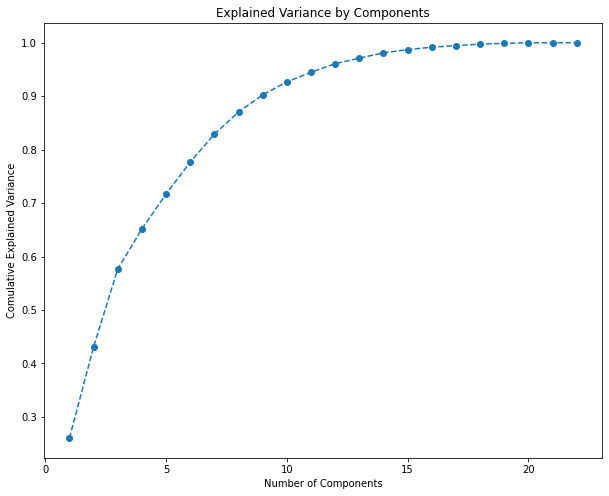

In [7]:
#The attribute shows how much variance is explained by each components
pca.explained_variance_ratio_

plt.figure(figsize=(10,8))
plt.plot(range(1,23),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Comulative Explained Variance');

As can be seen that 5 components explain more than 70% of the variance. Keeping more components would results in more variance explained, however, it would also make interpretation (which is the goal of our clustering), more difficult. Therefore, we keep only 5 principal components.

In [8]:
pca=PCA(n_components=5)
#Fit the model the our data with selected number of components.
pca.fit(df_std);

We then calculate the PC scores to attain the PC loadings.

In [9]:
pca.transform(df_std)
scores_pca=pca.transform(df_std)

The PC loadings are visualized in the heatmap below. The aim is to see, which components are related to which variables, and to which extent.

Text(0.5, 69.0, 'Principal Components')

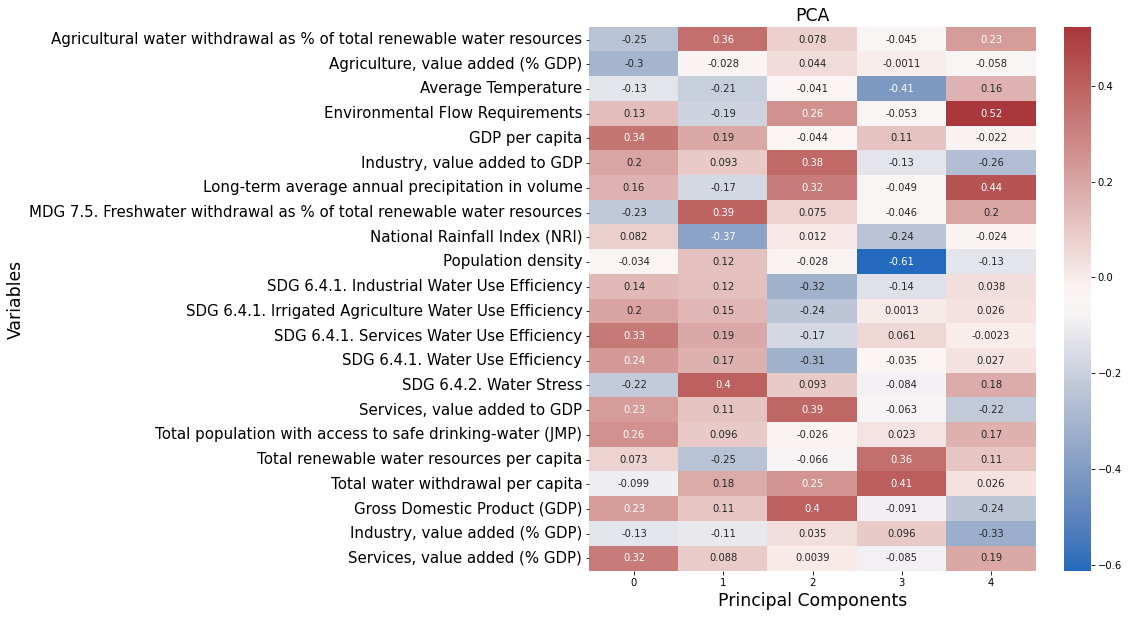

In [10]:
pcaloadings=pd.DataFrame(pca.components_)
pcaloadings.columns=df_pca.columns
pcaloadings=pcaloadings.T

plt.figure(figsize = (10,10))
ax = sns.heatmap(pcaloadings, annot=True,cmap='vlag')
ax.yaxis.set_tick_params(labelsize=15)
plt.title('PCA', fontsize='xx-large')
plt.ylabel('Variables', fontsize='xx-large')
plt.xlabel('Principal Components', fontsize='xx-large')
# plt.savefig('PCA.png', dpi=500)

- **PC1** is mildly linked with GDP, water use efficiency, and water stress. 
  - associated keywords: service economy - low agriculuture - high GDP - rich service economies - developed countires - high freshwater withdrawal
- **PC2** is related with water stress, water withdrawal (which is by definition related to water stress), and rainfall index. Note that here, precipitation and water stress are found to be negatively linked to one another. 
  - associated keywords: agriculutural economy - low rainfall - high water stress
- **PC3** is positively linked with GDP and negatively with water use efficiency. 
  - associated keywords: water use efficiency - industry & services - GDP
- **PC4** is linked with population density, temperature, rainfall, and water withdrawal. 
- **PC5** is strongly linked with precipitation and environmental flow requirements.
  - associated keywords: high rainfall + high environmental flow - tropical countries

We can see that water stress, and its related variables (water withdrawal, environmental flow requirements, etc.), are present in almost all components. Which confirms the idea that water stress, indeed, is an important variable to study. Moreover, precipitation, temperature, population density, and GDP were also present in multiple PCs.

## K-Means Clustering

Now, we will incorporate the obtained PCA scores in the K-means algorithm. We run the algorithm with a different number of clusters. Then, we determine the Within Cluster Sum of Squares or WCSS for each solution. Based on the values of the WCSS and an approach known as the *Elbow Method*, we make a decision about how many clusters to keep.

In [11]:
# We fit the k means using the transformed data from PCA
wcss=[]
for i in range(1,7):
 kmeans_pca=KMeans(n_clusters=i,init='k-means++',random_state=42)
 kmeans_pca.fit(scores_pca)
 wcss.append(kmeans_pca.inertia_)

The next step involves plotting the WCSS against the number of components on a graph.

Text(0, 0.5, 'wcss')

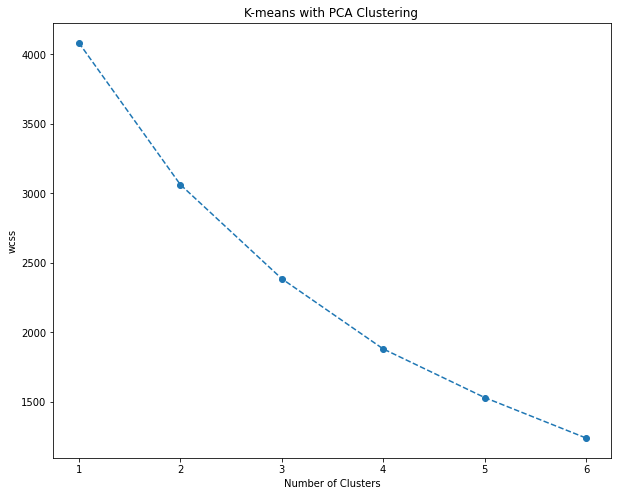

In [12]:
plt.figure(figsize=(10,8))
plt.plot(range(1,7),wcss,marker='o',linestyle='--')
plt.title('K-means with PCA Clustering ')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')

As mentioned, we now use the *Elbow Method*. The approach consists of looking for an elbow in the WCSS graph. Usually, the part of the graph before the elbow would be steeply declining, while the part after it – much smoother. In this instance, the elbow is not really clear, but is either 3 or 4. We chose 3 as the number of clusters, as 4 did not yield desirable results.

In [13]:
#We have 3 clusters, and same initrializer and random state as before.
kmeans_pca=KMeans(n_clusters=3,init='k-means++',random_state=21,n_init =50)
#We fit our data with the k-means model.
kmeans_pca.fit(scores_pca);

We will now include the clustering results and the PCA scores in the initial dataset.

In [14]:
#We create a new data frame with original features and PCA scores and assigned clusters.
df_pca_kmeans=pd.concat([df_pca.reset_index(),pd.DataFrame(scores_pca)],axis=1)
df_pca_kmeans.columns.values[-5:]=['PC1','PC2','PC3','PC4','PC5']
#The last columns we add contains the pca clustering labels.
df_pca_kmeans['Cluster']=kmeans_pca.labels_
df_pca_kmeans.set_index(['Area', 'Year'], inplace=True)
df_pca_kmeans.head()

Agricultural water withdrawal as % of total renewable water resources  \
Area        Year                                                                            
Afghanistan 1992.0                                          35.498101                       
            1997.0                                          31.427856                       
            2002.0                                          30.613807                       
            2007.0                                          30.613807                       
            2012.0                                          30.613807                       

                    Agriculture, value added (% GDP)  Average Temperature  \
Area        Year                                                            
Afghanistan 1992.0                         54.207106                12.61   
            1997.0                         62.416768                12.86   
            2002.0                         45.134344                13.91   
            2007.0                         35.265942                13.80   
            2012.0                         28.556142                13.25   

                    Environmental Flow Requirements  GDP per capita  \
Area        Year                                                      
Afghanistan 1992.0                            28.29      248.518890   
            1997.0                            28.29      164.092893   
            2002.0                            28.29      194.958382   
            2007.0                            28.29      389.985586   
            2012.0                            28.29      694.885618   

                    Industry, value added to GDP  \
Area        Year                                   
Afghanistan 1992.0                  5.530000e+08   
            1997.0                  4.220000e+08   
            2002.0                  9.150000e+08   
            2007.0                  2.600000e+09   
            2012.0                  4.360000e+09   

                    Long-term average annual precipitation in volume  \
Area        Year                                                       
Afghanistan 1992.0                                         213.48522   
            1997.0                                         213.48522   
            2002.0                                         213.48522   
            2007.0                                         213.48522   
            2012.0                                         213.48522   

                    MDG 7.5. Freshwater withdrawal as % of total renewable water resources  \
Area        Year                                                                             
Afghanistan 1992.0                                          35.910480                        
            1997.0                                          31.852952                        
            2002.0                                          31.045461                        
            2007.0                                          31.045461                        
            2012.0                                          31.045461                        

                    National Rainfall Index (NRI)  Population density  ...  \
Area        Year                                                       ...   
Afghanistan 1992.0                         304.98           22.187829  ...   
            1997.0                         233.00           29.649735  ...   
            2002.0                         185.00           34.618096  ...   
            2007.0                         185.00           41.510486  ...   
            2012.0                         185.00           47.730564  ...   

                    Total water withdrawal per capita  \
Area        Year                                        
Afghanistan 1992.0                        1619.567311   
            1997.0                        1075.032191   
            2002.0        

## Visualization
We will now isualize the results in 3 dimentions. First using PC1 to 3, and then with PC3 to 5.

In [15]:
cluster0 = df_pca_kmeans[df_pca_kmeans["Cluster"] == 0]
cluster1 = df_pca_kmeans[df_pca_kmeans["Cluster"] == 1]
cluster2 = df_pca_kmeans[df_pca_kmeans["Cluster"] == 2]

In [16]:
#trace1 is for 'Cluster 0'
trace1 = go.Scatter3d(
                    x = cluster0["PC1"],
                    y = cluster0["PC2"],
                    z = cluster0["PC3"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter3d(
                    x = cluster1["PC1"],
                    y = cluster1["PC2"],
                    z = cluster1["PC3"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)
#trace3 is for 'Cluster 2'
trace3 = go.Scatter3d(
                    x = cluster2["PC1"],
                    y = cluster2["PC2"],
                    z = cluster2["PC3"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Three Dimensions Using PCA"
layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

We can see that all three clusters are more or less centered around the origin (zero-mean). However, there are quite some outliers stretching far beyond the central cloud of points -- especially in cluster 1. Nevertheless, since the overall cloud is centered around the origin, we can conclude that the influence of outliers has not affected the PCA by shifting its the center of clouds towards the outliers.

The cluster 1 outliers share the following characteristics: high PC1 value, extreme (high or low) PC3 value. According to our interpretation of PCs, these countires are developed countires with high GDPs. The differentiation with PC3, is because some countires are rich, while being efficient with their water use (e.g. Western Europe), and others are rich without water use efficiency (e.g. China, US, etc.).

In [17]:
#trace1 is for 'Cluster 0'
trace1 = go.Scatter3d(
                    x = cluster0["PC3"],
                    y = cluster0["PC4"],
                    z = cluster0["PC5"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter3d(
                    x = cluster1["PC3"],
                    y = cluster1["PC4"],
                    z = cluster1["PC5"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)
#trace3 is for 'Cluster 2'
trace3 = go.Scatter3d(
                    x = cluster2["PC3"],
                    y = cluster2["PC4"],
                    z = cluster2["PC5"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Three Dimensions Using PCA"
layout = dict(title = title,
              xaxis= dict(title= 'PC3',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC5',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

From the second set of PCs, we can see that PC5 is also a distinguishing factors for outliers in cluster 0. These countires, according to our keywords, could be linked with tropical countries.

We also check the clusters for different years from 1992 to 2018.

In [18]:
# Cluster in different year
df_cluster=df_pca_kmeans.loc[:,['Cluster']]
df_cluster=df_cluster.unstack('Year')
df_cluster


Cluster                              \
Year                                   1992.0 1997.0 2002.0 2007.0 2012.0   
Area                                                                        
Afghanistan                                 2      2      2      2      2   
Argentina                                   0      0      0      0      0   
Australia                                   0      1      0      1      1   
Azerbaijan                                  2      2      2      2      2   
Bolivia (Plurinational State of)            0      0      0      0      0   
Brazil                                      0      0      0      0      0   
Canada                                      1      1      1      1      1   
Central African Republic                    0      0      0      0      0   
China                                       0      0      0      0      1   
Democratic People's Republic of Korea       0      0      0      0      0   
Denmark                                     1      1      1      1      1   
El Salvador                                 0      0      0      0      0   
Finland                                     1      1      1      1      1   
France                                      1      1      1      1      1   
Gabon                                       0      0      0      0      0   
Haiti                                       0      0      0      0      0   
India                                       0      0      0      0      0   
Indonesia                                   0      0      0      0      0   
Iraq                                        2      2      2      2      2   
Israel                                      2      2      2      1      1   
Italy                                       1      1      1      1      1   
Japan                                       1      1      1      1      1   
Malaysia                                    0      0      0      0      0   
Mexico                                      0      0      0      0      0   
Morocco                                     2      2      2      2      2   
New Zealand                                 0      1      1      1      1   
Pakistan                                    2      2      2      2      2   
Poland                                      0      0      0      0      0   
South Africa                                0      0      0      0      0   
Suriname                                    0      0      0      0      0   
Tajikistan                                  2      2      2      2      2   
Tunisia                                     2      2      2      2      2   
Ukraine                                     0      0      0      0      0   
United States of America                    1      1      1      1      1   
Uzbekistan                                  2      2      2      2      2   
Viet Nam                                    0      0      0      0      0   
Zimbabwe                                    0      0      0      0      0   

                                                     
Year                                  2017.0 2018.0  
Area                                                 
Afghanistan                                2      2  
Argentina                                  0      0  
Australia                                  1      1  
Azerbaijan                                 2      2  
Bolivia (Plurinational State of)           0      0  
Brazil                                     0      0  
Canada                                     1      1  
Central African Republic                   0      0  
China                                      1      1  
Democratic People's Republic of Korea      0      0  
Denmark                                    1      1  
El Salvador                                0      0  
Finland                                    1      1  
France                                     1      1  
Gabon                                  

Most of the countries remain in the same cluster over the years, but some change. For example, China is transitioning into a high GDP, service economy, and therefore moved from cluster 0 to 1.

It is also a good idea to visualize the results for 2018 on the world map.

In [21]:
# creating object
worldmap_chart = World()
# adding title
worldmap_chart.title = 'Result of Cluster in 2018'
# add data
worldmap_chart.add('Cluster 0', ['ar', 'bo', 'br', 'cf','sv','ga','ht','in','id', 'ma','mx','za','sr''vn','zw'])
worldmap_chart.add('Cluster 1', ['au', 'ca', 'dk','cn', 'fi', 'fr', 'il', 'it', 'jp', 'nz', 'pl','us'])
worldmap_chart.add('Cluster 2', ['af','az','cf','kr','ir','ma','tn','tj','ua','uz','pa'])
# rendering the svg to file
worldmap_chart.render_to_file('cluster.svg')


It is seen that cluster 1 corresponds to high GDP, developed countries. Cluster 0 corresponds countries with high water use, high rainfall, and high water stress. Cluster 0 corresponds with Middle-Eastern countires, which have low rainfall and high water stress.

This confirms our interpretation of the PCs.

## Conclusions

The research question to be tackled in this notebook was:
> Can countries in similar situations be grouped into clusters? 
> If yes, which clusters and what are the characteristics of each cluster?

Our answer, after this analysis, is: Yes.

We demonstrated that by using dimensionality reduction (PCA) structural patterns in the data become more clear, which can, in turn, be exploited via a clustering algorithm, K-means in this case.

The resulting 3 clusters could roughly be interpreted as the following:
1. Cluster 0: Somewhat corresponds to tropical countries with warm and rainy weather. They have low PC4, high PC5
    - economy: high population density, low industry, high agriculture, low GDP
    - environment: high precipitation, high temperature, low water withdrawal, high environmental flow
2. Cluster 1: Developed countires with high GDP, with China being somewhat of an outlier. They share the characteristic of having high PC1, and extreme PC3 (on both directions). Which can be interpreted as:
    - economy: high GDP, high service and instury, low agriculture
    - environment: very high/very low water use efficiency (because of China), low freshwater withdrawal, low water stress
3. Cluster 2: Middle-Eastern countries. These countries share the characteristic of having low PC1 and high PC2. This can be interpreted as:
    - economy: high agriculture, low industry and services, low GDP 
    - environment: low rainfall, high fresh water withdrawal (for agriculture), high water stress

## References

Wold S, Esbensen K, Geladi P. Principal component analysis[J]. Chemometrics and intelligent laboratory systems, 1987, 2(1-3): 37-52.https://doi.org/10.1016/0169-7439(87)80084-9


Arthur, David & Vassilvitskii, Sergei. (2007). K-Means++: The Advantages of Careful Seeding. Proc. of the Annu. ACM-SIAM Symp. on Discrete Algorithms. 8. 1027-1035. https://doi.org/10.1145/1283383.1283494. 

Steinley, Douglas & Brusco, Michael. (2011). Choosing the Number of Clusters in K-Means Clustering. Psychological methods. 16. 285-97. https://doi.org/10.1037/a0023346. 

Ding, Chris & He, Xiaofeng. (2004). K-Means Clustering Via Principal Component Analysis. Proceedings, Twenty-First International Conference on Machine Learning, ICML 2004.1. https://doi.org/10.1145/1015330.1015408
